In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
#Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt
# System libraries
from pathlib import Path
import os.path
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
# Dataset path
data = r"/content/drive/MyDrive/Dataset"
image_dir = Path(data)


In [ ]:
# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

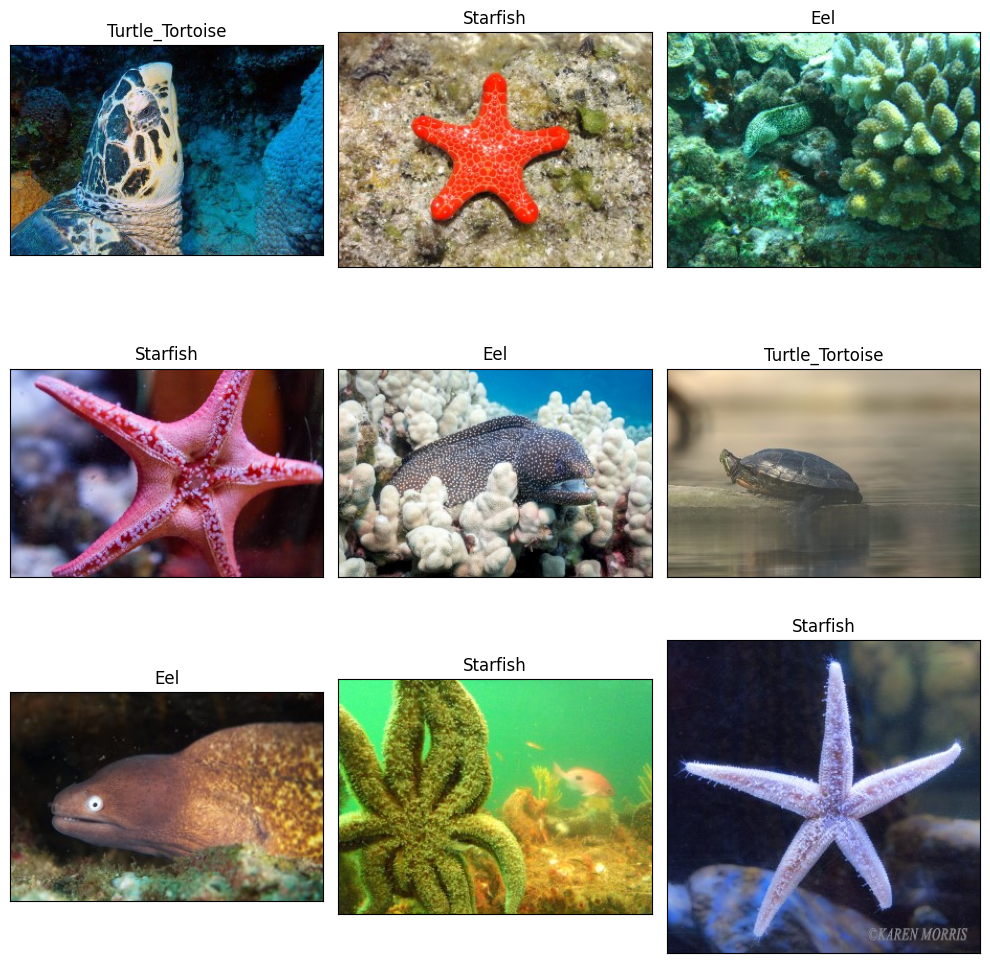

Found 2981 images belonging to 5 classes.
Found 741 images belonging to 5 classes.


In [ ]:
  # Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
random_index = np.random.randint(0, len(image_df), 9)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

input_size = (224, 224)
#tănng cường dữ liệu.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_images = train_datagen.flow_from_directory(
    data,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_images = train_datagen.flow_from_directory(
    data,
    target_size=input_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


In [ ]:
# Số lượng lớp của dữ liệu
num_classes = len(train_images.class_indices)

In [ ]:
# Xây dựng mô hình cuối cùng với số lượng lớp đúng
mobile_model = Sequential()

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(input_size[0], input_size[1], 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
#khóa cứng toàn bộ bộ tham số , ngoại trừ bộ top.
pretrained_model.trainable = False
mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(512, activation='relu'))
mobile_model.add(Dropout(0.2))
mobile_model.add(Dense(num_classes, activation='softmax'))  # Số lượng lớp đúng
mobile_model.summary()
mobile_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 2916421 (11.13 MB)
Trainable params: 658437 (

In [ ]:
# Bắt đầu fine-tuning
fine_tuning_lr = 1e-4
mobile_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=fine_tuning_lr), metrics=['accuracy'])

In [ ]:
from tensorflow .keras.callbacks import ModelCheckpoint

# Định nghĩa callback để lưu mô hình tại epoch có độ chính xác trên tập validation cao nhất
checkpoint = ModelCheckpoint('best.hdf5', monitor='val_accuracy', save_best_only=True, mode='max')

# Tiến hành huấn luyện mô hình với fine-tuning và sử dụng callback để lưu lại mô hình tốt nhất
history_fine_tuning = mobile_model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=10,
    callbacks=[checkpoint]
)

class_mapping = {v: k for k, v in train_images.class_indices.items()}
# Lưu lại mô hình cuối cùng với tên nhãn là tên của các thư mục
mobile_model.save('model_with_labels.h5')

Epoch 1/10
94/94 [==============================] - 254s 3s/step - loss: 0.0916 - accuracy: 0.9701 - val_loss: 0.1290 - val_accuracy: 0.9582
Epoch 2/10
94/94 [==============================] - 214s 2s/step - loss: 0.1015 - accuracy: 0.9638 - val_loss: 0.1221 - val_accuracy: 0.9582
Epoch 3/10
94/94 [==============================] - 222s 2s/step - loss: 0.0898 - accuracy: 0.9688 - val_loss: 0.1074 - val_accuracy: 0.9649
Epoch 4/10
94/94 [==============================] - 213s 2s/step - loss: 0.0899 - accuracy: 0.9691 - val_loss: 0.1073 - val_accuracy: 0.9568
Epoch 5/10
94/94 [==============================] - 222s 2s/step - loss: 0.0824 - accuracy: 0.9685 - val_loss: 0.1082 - val_accuracy: 0.9676
Epoch 6/10
94/94 [==============================] - 210s 2s/step - loss: 0.0762 - accuracy: 0.9752 - val_loss: 0.1168 - val_accuracy: 0.9582
Epoch 7/10
94/94 [==============================] - 220s 2s/step - loss: 0.0797 - accuracy: 0.9718 - val_loss: 0.1275 - val_accuracy: 0.9528
Epoch 8/10
94

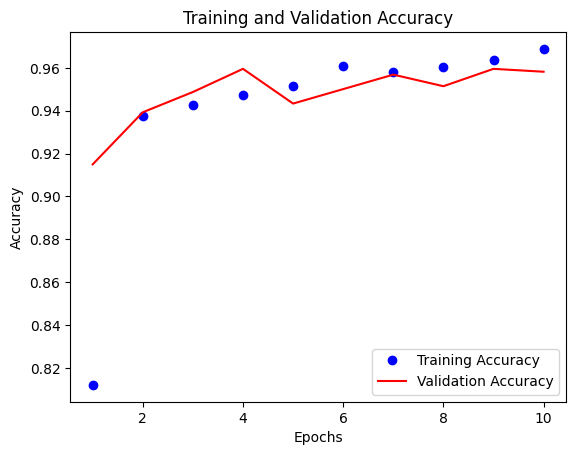

In [ ]:
# Lấy dữ liệu từ lịch sử huấn luyện
train_accuracy = history_fine_tuning.history['accuracy']
val_accuracy = history_fine_tuning.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Vẽ biểu đồ độ chính xác
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_label(image_path, model, class_mapping):
    # Load ảnh và tiền xử lý
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Chuẩn hóa dữ liệu
    img_array = np.expand_dims(img_array, axis=0)

    # Dự đoán xác suất của từng lớp
    predictions = model.predict(img_array)

    # Hiển thị ảnh đầu vào
    plt.imshow(img)
    plt.axis('off')
    # Lấy chỉ số của lớp có xác suất cao nhất
    predicted_class_index = np.argmax(predictions)
    # Ánh xạ chỉ số lớp sang tên lớp
    predicted_label = class_mapping[predicted_class_index]
    # In ra nhãn dán và xác suất dự đoán của từng nhãn
    for i, prob in enumerate(predictions[0]):
        label = class_mapping[i]
        plt.text(0, -10 - i*10, f"{label}: {prob * 100:.2f}%", fontsize=10)

    plt.show()

1/1 [==============================] - 1s 980ms/step


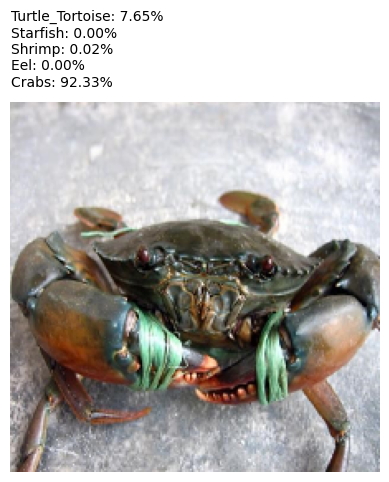

In [ ]:
# Gọi hàm predict_label với đường dẫn đến ảnh input
image_path = r'/content/drive/MyDrive/Data_Test/Test4.jpg'
predict_label(image_path, mobile_model, class_mapping)

In [ ]:
import tensorflow as tf
# Load model từ file .h5
model = tf.keras.models.load_model('best.hdf5')
# Khởi tạo một bộ converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Thực hiện convert
tflite_model = converter.convert()
# Ghi vào file .tflite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)